## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Custom packages
import unets as un
import tf_utils as tfu

## Increasing Depth

In [2]:
# Load training history from JSON file
with open('Training-history/training_history_unet_full_1.json', 'r') as f1:
    loaded_history_1 = json.load(f1)

with open('Training-history/training_history_unet_full_2.json', 'r') as f2:
    loaded_history_2 = json.load(f2)
    
with open('Training-history/training_history_unet_full_3.json', 'r') as f3:
    loaded_history_3 = json.load(f3)

with open('Training-history/training_history_unet_full_4.json', 'r') as f4:
    loaded_history_4 = json.load(f4)

### Training and Validation losses achieved by training the basic UNet architecture on ISIC-Merged.

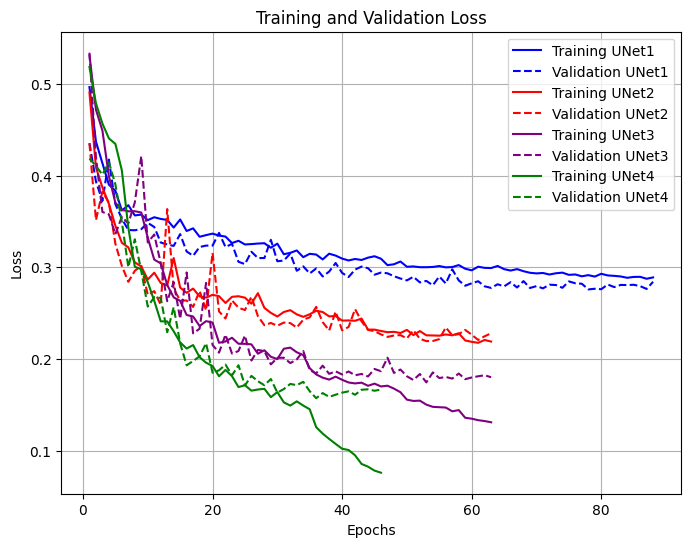

In [4]:
# Access training and validation loss
train_loss_1 = loaded_history_1['loss']
val_loss_1 = loaded_history_1['val_loss']

train_loss_2 = loaded_history_2['loss']
val_loss_2 = loaded_history_2['val_loss']

train_loss_3 = loaded_history_3['loss']
val_loss_3 = loaded_history_3['val_loss']

train_loss_4 = loaded_history_4['loss']
val_loss_4 = loaded_history_4['val_loss']

epochs_1 = range(1, len(train_loss_1) + 1)
epochs_2 = range(1, len(train_loss_2) + 1)
epochs_3 = range(1, len(train_loss_3) + 1)
epochs_4 = range(1, len(train_loss_4) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_1, train_loss_1, label='Training UNet1', color='blue')
plt.plot(epochs_1, val_loss_1, label='Validation UNet1', color='blue', linestyle='--')
plt.plot(epochs_2, train_loss_2, label='Training UNet2', color='red')
plt.plot(epochs_2, val_loss_2, label='Validation UNet2', color='red', linestyle='--')
plt.plot(epochs_3, train_loss_3, label='Training UNet3', color='purple')
plt.plot(epochs_3, val_loss_3, label='Validation UNet3', color='purple', linestyle='--')
plt.plot(epochs_4, train_loss_4, label='Training UNet4', color='green')
plt.plot(epochs_4, val_loss_4, label='Validation UNet4', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Training and Validation jaccard index achieved by training the basic UNet architecture on ISIC-Merged.

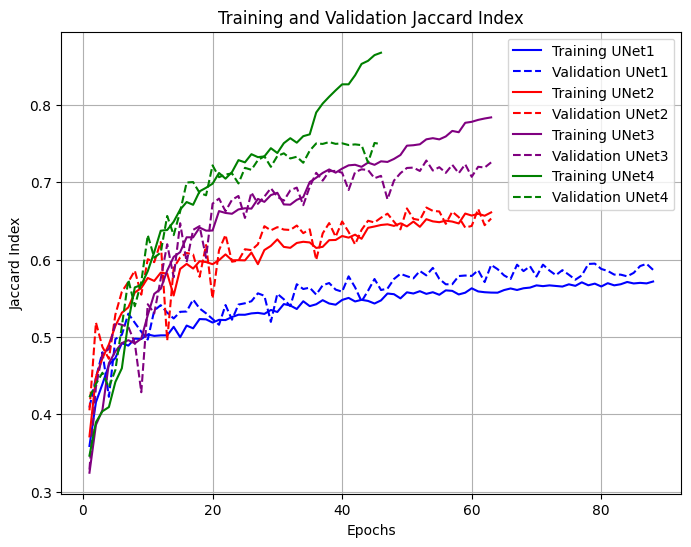

In [5]:
# Access training and validation jaccard index
train_jaccard_idx_1 = loaded_history_1['jaccard_index']
val_jaccard_idx_1 = loaded_history_1['val_jaccard_index']

train_jaccard_idx_2 = loaded_history_2['jaccard_index']
val_jaccard_idx_2 = loaded_history_2['val_jaccard_index']

train_jaccard_idx_3 = loaded_history_3['jaccard_index']
val_jaccard_idx_3 = loaded_history_3['val_jaccard_index']

train_jaccard_idx_4 = loaded_history_4['jaccard_index']
val_jaccard_idx_4 = loaded_history_4['val_jaccard_index']


plt.figure(figsize=(8, 6))
plt.plot(epochs_1, train_jaccard_idx_1, label='Training UNet1', color='blue')
plt.plot(epochs_1, val_jaccard_idx_1, label='Validation UNet1', color='blue', linestyle='--')
plt.plot(epochs_2, train_jaccard_idx_2, label='Training UNet2', color='red')
plt.plot(epochs_2, val_jaccard_idx_2, label='Validation UNet2', color='red', linestyle='--')
plt.plot(epochs_3, train_jaccard_idx_3, label='Training UNet3', color='purple')
plt.plot(epochs_3, val_jaccard_idx_3, label='Validation UNet3', color='purple', linestyle='--')
plt.plot(epochs_4, train_jaccard_idx_4, label='Training UNet4', color='green')
plt.plot(epochs_4, val_jaccard_idx_4, label='Validation UNet4', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Index')
plt.title('Training and Validation Jaccard Index')
plt.legend()
plt.grid(True)
plt.show()

## Load model

In [ ]:
# Instantiate the model
unet = un.UNet4cSE(input_size=(256, 256, 3), num_classes=1)

# Call the model with a random input to build the model
out = unet.call(tf.random.normal((1, 256, 256, 3)))

unet.build((1, 256, 256, 3))

# Restore the weights
unet.load_weights("Models//unet_cse_aug_4_DS.weights.h5")


# Testing

### Preparing Testing set

In [9]:
# Set the directory paths
test_image_folder = 'ISIC-Merged\\test_images'
test_mask_folder = 'ISIC-Merged\\test_masks'

# Load the dataset
test_dataset = tfu.load_data(test_image_folder, test_mask_folder)

# Check the dataset shapes (optional)
for images, masks in test_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


### Compile and Evaluate

In [10]:
# Compile the model
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tfu.bce_dice_loss, metrics=[tfu.jaccard_index])

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = unet.evaluate(test_dataset)

# Visualizations

### Test set visualizations

In [ ]:
test_images_dir = '/kaggle/input/isic-2016-2017/split/test_images'
test_masks_dir = '/kaggle/input/isic-2016-2017/split/test_masks'

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get sorted image filenames (only images, not masks)
image_filenames = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg")])

# Iterate Over Images and Select Corresponding Mask
image_list = []
y_true_list = []
y_pred_list = []

for img_filename in image_filenames:
    img_path = os.path.join(test_images_dir, img_filename)

    # Construct the corresponding mask filename
    mask_filename = img_filename.replace(".jpg", "_segmentation.png")
    mask_path = os.path.join(test_masks_dir, mask_filename)

    # Load image and mask using your existing functions
    image_np = tfu.load_image(img_path).numpy()
    mask_tensor = tfu.load_mask(mask_path)  # Full mask path is passed correctly

    if mask_tensor is None:
        print(f" Skipping: No mask found for {img_filename}")
        continue  # Skip this image if the mask is missing

    mask_np = mask_tensor.numpy()

    # Get model prediction
    predicted_mask = unet.predict(np.expand_dims(image_np, axis=0), verbose=0)  # Add batch dimension

    # Threshold prediction to binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Store correctly paired results
    image_list.append(image_np)
    y_true_list.append(mask_np)
    y_pred_list.append(predicted_mask.squeeze())  # Remove batch dimension

# Convert Lists to Arrays
image_data = np.array(image_list)  # Shape: (N, 256, 256, 3)
y_true = np.array(y_true_list)  # Shape: (N, 256, 256, 1)
y_pred = np.array(y_pred_list)  # Shape: (N, 256, 256, 1)


In [ ]:
# Visualize First Image-Mask-Prediction Pairs
num_images_to_show = 20
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(20, 20))

for i in range(num_images_to_show):
    axes[i, 0].imshow(image_data[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(np.squeeze(y_true[i]), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

### Dark Skin Visualization

In [ ]:
test_images_dir = 'Dark-skin-test/dark_skin_images'
test_masks_dir = 'Dark-skin-test/dark_skin_masks'

In [ ]:
# Get sorted image filenames (only images, not masks)
image_filenames = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg")])

# Iterate Over Images and Select Corresponding Mask
image_list = []
y_true_list = []
y_pred_list = []

for img_filename in image_filenames:
    img_path = os.path.join(test_images_dir, img_filename)

    # Construct the corresponding mask filename
    mask_filename = img_filename.replace("_orig.jpg", "_contour.png")
    mask_path = os.path.join(test_masks_dir, mask_filename)

    # Load image and mask using your existing functions
    image_np = tfu.load_image(img_path).numpy()
    mask_tensor = tfu.load_mask(mask_path)  # Full mask path is passed correctly

    if mask_tensor is None:
        print(f" Skipping: No mask found for {img_filename}")
        continue  # Skip this image if the mask is missing

    mask_np = mask_tensor.numpy()

    # Get model prediction
    predicted_mask = unet.predict(np.expand_dims(image_np, axis=0), verbose=0)  # Add batch dimension

    # Threshold prediction to binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Store correctly paired results
    image_list.append(image_np)
    y_true_list.append(mask_np)
    y_pred_list.append(predicted_mask.squeeze())  # Remove batch dimension

# Convert Lists to Arrays
image_data = np.array(image_list)  # Shape: (N, 256, 256, 3)
y_true = np.array(y_true_list)  # Shape: (N, 256, 256, 1)
y_pred = np.array(y_pred_list)  # Shape: (N, 256, 256, 1)


In [ ]:
from skimage.measure import find_contours

num_images_to_show = 8
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 10))  # 1 row, 8 columns

for i in range(num_images_to_show):
    # Plot the original image
    axes[i].imshow(image_data[i])
    axes[i].axis("off")
    
    # Find contours for the ground truth mask
    contours_true = find_contours(np.squeeze(y_true[i]), level=0.5)
    
    # Plot the contours on top of the original image (ground truth)
    for contour in contours_true:
        axes[i].plot(contour[:, 1], contour[:, 0], color='g', linewidth=1, linestyle='--')  # Green dashed line

    # Find contours for the predicted mask
    contours_pred = find_contours(np.squeeze(y_pred[i]), level=0.5)
    
    # Plot the contours on top of the original image (predicted)
    for contour in contours_pred:
        axes[i].plot(contour[:, 1], contour[:, 0], color='r', linewidth=1, linestyle='--')  # Red dashed line

plt.tight_layout()
plt.show()
